# Loan Approval Prediction:

__About Company__ <br>
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

__Problem__ <br>
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

#### Dataset Description:

| Variable | Description | 
|------|------|
| Loan_ID | Unique Loan ID | 
| Gender | Male/ Female | 
| Married | Applicant married (Y/N) | 
| Dependents | Number of dependents | 
| Education | Applicant Education (Graduate/ Under Graduate) | 
| Self_Employed | Self employed (Y/N) | 
| ApplicantIncome | Applicant income | 
| CoapplicantIncome | Coapplicant income | 
| LoanAmount | Loan amount in thousands | 
| Loan_Amount_Term | Term of loan in months | 
| Credit_History | credit history meets guidelines | 
| Property_Area | Urban/ Semi Urban/ Rural | 
| Loan_Status | Loan approved (Y/N) |

In [1]:
################### Importing Libraries ######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as mso
import seaborn as sns
import warnings
import os
import scipy

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce 
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler,MaxAbsScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/kaggle/input/loan-predication/train_u6lujuX_CVtuZ9i (1).csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


##### Observations:
1. We can see there are total 13 columns including target variable, all of them are self explanatory. 
2. We also see some missing values, lets take stock of missing columns and what are the possible values for categorical and numerical columns

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

We notice that the dataset contains a lot of null values. Since this is a small dataset we should not simply drop them. We will look for imputing them.

### DATA VISUALIZATION AND EDA

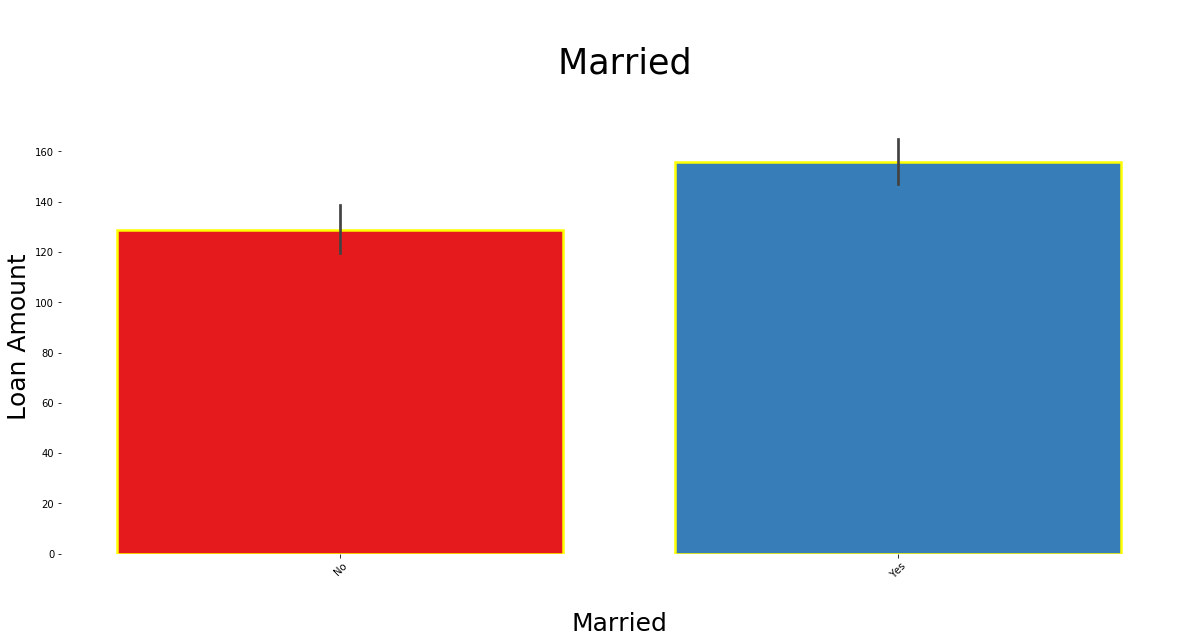

In [5]:
plt.subplots(figsize=(20,8))
p = sns.barplot(x=df["Married"],y=df["LoanAmount"],palette="Set1", saturation=2, edgecolor = "yellow", linewidth = 2.5,)
p.axes.set_title("\n Married\n", fontsize=35)
plt.ylabel("Loan Amount" , fontsize = 25)
plt.xlabel("\nMarried" , fontsize = 25)

plt.xticks(rotation = 45)


sns.despine(left=True, bottom=True)
plt.show()

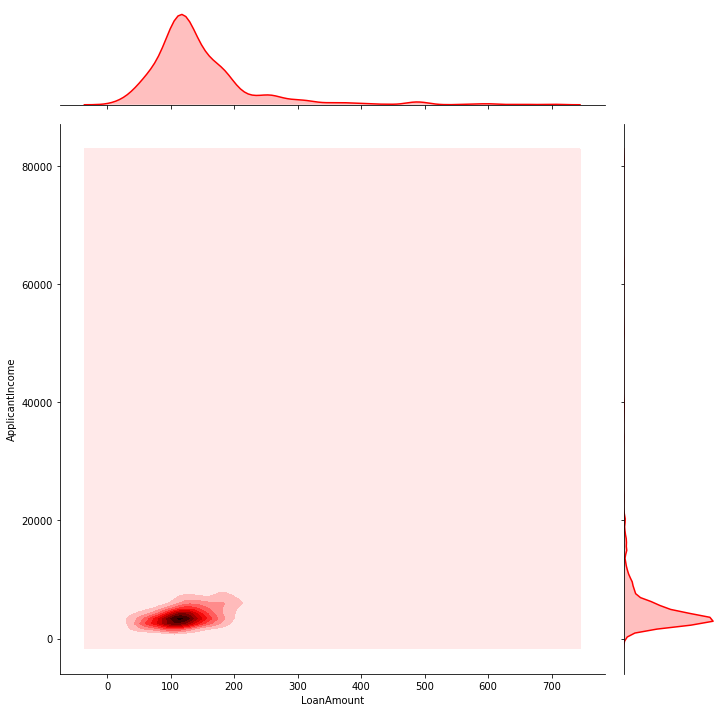

In [6]:
sns.jointplot(data=df, height = 10, x="LoanAmount", y="ApplicantIncome", hue = "Gender",  kind="kde", color = "red");

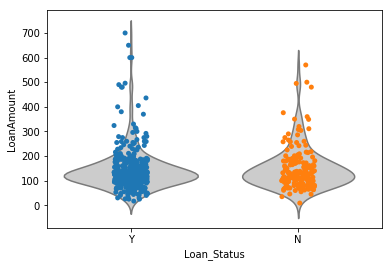

In [7]:
ax = sns.violinplot(x="Loan_Status", y="LoanAmount", data=df,inner=None, color=".8")
ax = sns.stripplot(x="Loan_Status", y="LoanAmount", data=df)

### FEATURE ENGINEERING

In [3]:
df = df.drop('Loan_ID',axis=1)

In [4]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [6]:
# Making Dictionaries of ordinal features

Dependents_map =  {'0': 0,'1':1,'2':2,'3+':3 }

Gender_map = {
    'Male'    :    0,
    'Female'  :    1,
} 
    
Married_map = {
    'No'           :    0,
    'Yes'          :    1, 
}

Education_map ={
    'Not Graduate': 0,
    'Graduate'    : 1
}

Property_Area_map ={
    'Urban' : 2,
    'Rural' : 0, 
    'Semiurban': 1        
}

Self_Employed_map ={
    'No': 0,
    'Yes': 1
}

Loan_Status_map = {
    'Y':1,
    'N': 0
}

# Transform categorical features into numerical features

def encode(df_pre):
    df_pre.loc[:,'Dependents'] = df_pre['Dependents'].map(Dependents_map)
    df_pre.loc[:,'Gender'] = df_pre['Gender'].map(Gender_map)
    df_pre.loc[:,'Married'] = df_pre['Married'].map(Married_map)
    df_pre.loc[:,'Education'] = df_pre['Education'].map(Education_map)
    df_pre.loc[:,'Property_Area'] = df_pre['Property_Area'].map(Property_Area_map)
    df_pre.loc[:,'Loan_Status'] = df_pre['Loan_Status'].map(Loan_Status_map)
    df_pre.loc[:,'Self_Employed'] = df_pre['Self_Employed'].map(Self_Employed_map)
  
    return df_pre

df = encode(df)

In [7]:
df['Dependents'].value_counts()

0.0    345
1.0    102
2.0    101
3.0     51
Name: Dependents, dtype: int64

In [8]:
num_var_mean = ['LoanAmount']
num_var_mostfrequent = ['Loan_Amount_Term','Gender','Married','Self_Employed','Credit_History','Dependents']
num_no_missingvalue = ['Education','ApplicantIncome','CoapplicantIncome','Property_Area','Loan_Status']

num_var_meanimputer = Pipeline(steps=[("imputer",SimpleImputer(strategy='mean'))])
num_var_most_frequent = Pipeline(steps=[("imputer",SimpleImputer(strategy='most_frequent'))])

In [9]:
# imputation transformer
trf1 = ColumnTransformer([("mean_imputer", num_var_meanimputer, num_var_mean),
                        ("most_frequent_imputer", num_var_most_frequent, num_var_mostfrequent)
    
],remainder='passthrough')

In [10]:
# Scaling
num_var_scale = [5, 6, 7,8]
trf2 = ColumnTransformer([
    ('scale',MinMaxScaler(),num_var_scale)
])

In [11]:
# train the model
from sklearn.ensemble import GradientBoostingClassifier
trf3 = GradientBoostingClassifier(random_state=0)

In [12]:
pipe_dec = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3)
])

In [13]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['Loan_Status']),
                                                 df['Loan_Status'],
                                                 test_size=0.2,
                                                random_state=42)

In [20]:
# train
pipe_dec.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('trf1', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('mean_imputer', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
      ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [21]:
accuracy = pipe_dec.score(X_train, y_train)
print(accuracy)

0.8737270875763747


In [22]:
# Predict
y_pred = pipe_dec.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy Score: ",accuracy_score(y_test,y_pred).round(2)*100,"%")

Accuracy Score:  75.0 %


In [23]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score

print("cross_val_score     : ",cross_val_score(pipe_dec, X_train, y_train, cv=5, scoring='accuracy').round(3)*100,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("cross_val_score mean: ",cross_val_score(pipe_dec, X_train, y_train, cv=5, scoring='accuracy').mean().round(2)*100,"%")

cross_val_score     :  [74.7 74.7 72.4 74.5 79.4] %
--------------------------------------------------------
cross_val_score mean:  75.0 %


In [24]:
import joblib

# Save pipeline to file "pipe.joblib"
joblib.dump(pipe_dec,"pipe.joblib")

['pipe.joblib']

In [18]:
# Code here
pipe_dec.named_steps

{'trf1': ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('mean_imputer', Pipeline(memory=None,
      steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
        verbose=0))]), ['LoanAmount']), ('most_frequent_imputer', Pipeline(memory=None,
      steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
        strategy='most_frequent', verbose=0))]), ['Loan_Amount_Term', 'Gender', 'Married', 'Self_Employed', 'Credit_History', 'Dependents'])]),
 'trf2': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1)), [5, 6, 7, 8])]),
 'trf3': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_le

In [15]:
# gridsearchcv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

# The parameters of THE DIFFERENT STAGES OF THE PIPELINE to be fit

param_grid = [
    {
        "trf1__mean_imputer__imputer__strategy": ["mean", "median"],
        "trf3__learning_rate": [0.05, 0.1, 1.0, 10.0],
        "trf3__n_estimators":[140, 150], 
        "trf3__max_depth":[3, 4, 5],
        "trf3__subsample":[0.5,0.8],
        "trf3__validation_fraction": [0.2,0.3],
        "trf3__criterion": ["friedman_mse",  "mae"]
    }
]


cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
# The grid search object
grid_gbc = GridSearchCV(pipe_dec, 
                      param_grid=param_grid, 
                      scoring='f1',
                      cv = cv,
                      verbose=1, 
                      n_jobs=-1)
grid_gbc.get_params()

{'cv': StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
             train_size=None),
 'error_score': 'raise-deprecating',
 'estimator__memory': None,
 'estimator__steps': [('trf1',
   ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('mean_imputer', Pipeline(memory=None,
        steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
          verbose=0))]), ['LoanAmount']), ('most_frequent_imputer', Pipeline(memory=None,
        steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='most_frequent', verbose=0))]), ['Loan_Amount_Term', 'Gender', 'Married', 'Self_Employed', 'Credit_History', 'Dependents'])])),
  ('trf2',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('scale', MinMaxScaler(copy=True,

In [16]:
grid_gbc.fit(X_train,y_train)

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  6.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('trf1', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('mean_imputer', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
      ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'trf1__mean_imputer__imputer__strategy': ['mean', 'median'], 'trf3__learning_rate': [0.05, 0.1, 1.0, 10.0], 'trf3__n_estimators': [140, 150], 'trf3__max_depth': [3, 4, 5], 'trf3__subsample': [0.5, 0.8], 'trf3__validation_fraction': [0.2, 0.3], 'trf3__criterion': ['friedman_mse', 'mae']}],
       pre_dispatch='2*n_jobs', refit=T

In [17]:
print (grid_gbc.best_score_)
print("\033[1m--------------------------------------------------------\033[0m")
print (grid_gbc.best_params_)
print("\033[1m--------------------------------------------------------\033[0m")
print (grid_gbc.best_estimator_)

0.8697830875765313
--------------------------------------------------------
{'trf1__mean_imputer__imputer__strategy': 'mean', 'trf3__criterion': 'mae', 'trf3__learning_rate': 0.05, 'trf3__max_depth': 3, 'trf3__n_estimators': 150, 'trf3__subsample': 0.8, 'trf3__validation_fraction': 0.2}
--------------------------------------------------------
Pipeline(memory=None,
     steps=[('trf1', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('mean_imputer', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
      ...=0, subsample=0.8, tol=0.0001,
              validation_fraction=0.2, verbose=0, warm_start=False))])


In [18]:

### Using the best parameters from the grid-search.
best_model = grid_gbc.best_estimator_

tr_percnt = round(best_model.score(X_train, y_train) * 100, 2)
te_percnt = best_model.score(X_test,y_test).round(2)*100

print("Training Accuracy with GridSearch :",tr_percnt  ,"%")
print("Model Accuracy with GridSearch    :",te_percnt ,"%")
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy with GridSearch : 81.87 %
Model Accuracy with GridSearch    : 79.0 %
--------------------------------------------------------


In [19]:
# Alternatively, you can use other evaluation metrics
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
classification_report = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

   micro avg       0.79      0.79      0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



In [22]:
!pip install --upgrade scikit-learn

Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x793621798d68>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',)': /simple/scikit-learn/
Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x793619498cc0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',)': /simple/scikit-learn/
Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x793619498b38>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',)': /simple/scikit-learn/
Retrying (Retry(total=1, connec

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

ImportError: cannot import name 'ConfusionMatrixDisplay'

## RANDOM FOREST CLASSIFIER

In [29]:
# gridsearchcv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score

# The parameters of THE DIFFERENT STAGES OF THE PIPELINE to be fit

param_grid = [
    {
        "trf1__mean_imputer__imputer__strategy": ["mean", "median"],
        "trf3": [RandomForestClassifier(oob_score=True, random_state=0, verbose=1)],
        "trf3__n_estimators":[140, 150, 200, 500], 
        "trf3__max_depth":[3, 4, 5],
       'trf3__max_features': ['auto', 'sqrt', 'log2'],
    'trf3__max_depth' : [4,5,6,7,8],
    'trf3__criterion' :['gini', 'entropy']

    }
]


cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
# The grid search object
grid_gbc = GridSearchCV(pipe_dec, 
                      param_grid=param_grid, 
                      scoring='f1',
                      cv = cv,
                      verbose=1, 
                      n_jobs=-1)
grid_gbc.get_params()

{'cv': StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
             train_size=None),
 'error_score': 'raise-deprecating',
 'estimator__memory': None,
 'estimator__steps': [('trf1',
   ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('mean_imputer', Pipeline(memory=None,
        steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
          verbose=0))]), ['LoanAmount']), ('most_frequent_imputer', Pipeline(memory=None,
        steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='most_frequent', verbose=0))]), ['Loan_Amount_Term', 'Gender', 'Married', 'Self_Employed', 'Credit_History', 'Dependents'])])),
  ('trf2',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('scale', MinMaxScaler(copy=True,

In [30]:
grid_gbc.fit(X_train,y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.1s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('trf1', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('mean_imputer', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
      ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'trf1__mean_imputer__imputer__strategy': ['mean', 'median'], 'trf3': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
       ..., 6, 7, 8], 'trf3__max_features': ['aut

In [31]:
print (grid_gbc.best_score_)
print("\033[1m--------------------------------------------------------\033[0m")
print (grid_gbc.best_params_)
print("\033[1m--------------------------------------------------------\033[0m")
print (grid_gbc.best_estimator_)

0.8746089772652904
--------------------------------------------------------
{'trf1__mean_imputer__imputer__strategy': 'mean', 'trf3': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=True, random_state=0, verbose=1, warm_start=False), 'trf3__criterion': 'entropy', 'trf3__max_depth': 4, 'trf3__max_features': 'auto', 'trf3__n_estimators': 140}
--------------------------------------------------------
Pipeline(memory=None,
     steps=[('trf1', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('mean_imputer', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missin

In [32]:
### Using the best parameters from the grid-search.
best_model = grid_gbc.best_estimator_

tr_percnt = round(best_model.score(X_train, y_train) * 100, 2)
te_percnt = best_model.score(X_test,y_test).round(2)*100

print("Training Accuracy with GridSearch :",tr_percnt  ,"%")
print("Model Accuracy with GridSearch    :",te_percnt ,"%")
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy with GridSearch : 81.47 %
Model Accuracy with GridSearch    : 79.0 %
--------------------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished


In [33]:
# Alternatively, you can use other evaluation metrics
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
classification_report = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

   micro avg       0.79      0.79      0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished
